In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [2]:
from pathlib import Path

# Configurable parts
SOURCE = "dukascopy"
SYMBOL = "usdjpy"
MINUTES = 1
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

# Build base name
BASE_NAME = f"{SOURCE}-{SYMBOL}-tick-{START_DATE}-{END_DATE}"
RESAMPLED_NAME = f"{SOURCE}-{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"
# Base directories
BASE_DIR = Path("../data")
RAW_DIR = BASE_DIR / "raw"
RESAMPLED_DIR = BASE_DIR / "resampled"

# Final paths
RAW_FILE_PATH = RAW_DIR / f"{BASE_NAME}.csv"
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"

In [3]:
def resample_to_ohlcv(df, minutes: int):
    # Avoid unnecessary full copy if not modifying inplace
    df = df[['timestamp', 'askPrice', 'bidPrice', 'askVolume', 'bidVolume']]

    # Minimal temporary columns
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['mid'] = (df['askPrice'] + df['bidPrice']) / 2
    df['volume'] = df['askVolume'] + df['bidVolume']
    df['spread'] = df['askPrice'] - df['bidPrice']

    # Only keep what we need to resample
    df.set_index('timestamp', inplace=True)
    df = df[['mid', 'volume', 'spread']]

    # Perform resampling with reduced footprint
    ohlcv = df.resample(f'{minutes}min').agg({
        'mid': ['first', 'max', 'min', 'last'],
        'volume': 'sum',
        'spread': 'mean'
    })

    # Flatten column names
    ohlcv.columns = ['open', 'high', 'low', 'close', 'volume', 'spread']
    ohlcv = ohlcv.dropna(subset=['open'])  # Drop rows where no data existed in the interval

    ohlcv.reset_index(inplace=True)
    return ohlcv


In [4]:
import pandas as pd
import numpy as np

def check_time_continuity(ohlcv_df, minutes=60):
    # Ensure timestamp is in datetime format
    ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'])

    # Set timestamp as index for easier continuity check
    ohlcv_df.set_index('timestamp', inplace=True)

    # Generate a full datetime index at 1-minute intervals from the first to the last timestamp
    full_time_index = pd.date_range(start=ohlcv_df.index.min(), end=ohlcv_df.index.max(), freq=f"{minutes}min")

    # Find missing timestamps (gaps in the data)
    missing_timestamps = full_time_index.difference(ohlcv_df.index)

    # Print missing statistics
    missing_count = len(missing_timestamps)
    total_count = len(full_time_index)
    missing_percentage = (missing_count / total_count) * 100
    
    print(f"Total data points: {total_count}")
    print(f"Missing data points: {missing_count}")
    print(f"Percentage of missing data: {missing_percentage:.2f}%")
    print(f"First missing timestamp: {missing_timestamps.min() if missing_timestamps.size > 0 else 'N/A'}")
    print(f"Last missing timestamp: {missing_timestamps.max() if missing_timestamps.size > 0 else 'N/A'}")
    ohlcv_df.reset_index(inplace=True)
    return missing_timestamps



In [5]:
df = pd.read_csv(RAW_FILE_PATH)

In [6]:
df.shape

(163024077, 5)

In [7]:
df.head()

,timestamp,askPrice,bidPrice,askVolume,bidVolume
0,1577916000219,108.786,108.730,750.0,750.000000
1,1577916000433,108.790,108.730,750.0,750.000000
2,1577916023533,108.790,108.729,750.0,750.000000
3,1577916028663,108.790,108.728,750.0,1309.999943
4,1577916041516,108.791,108.728,750.0,560.000002


In [8]:
df = resample_to_ohlcv(df, minutes=MINUTES)

In [9]:
df

,timestamp,open,high,low,close,volume,spread
0,2020-01-01 22:00:00,108.7580,108.7600,108.7580,108.7590,9179.999948,0.060667
1,2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012,0.060333
2,2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000,0.058667
3,2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010,0.059857
4,2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024,0.055100
...,...,...,...,...,...,...,...
1860635,2024-12-30 23:55:00,157.0100,157.0110,157.0075,157.0080,206939.997196,0.011818
1860636,2024-12-30 23:56:00,157.0075,157.0090,157.0075,157.0075,127200.000405,0.010920
1860637,2024-12-30 23:57:00,157.0035,157.0095,156.9900,157.0070,234090.000987,0.007978
1860638,2024-12-30 23:58:00,157.0080,157.0080,157.0000,157.0015,317940.000176,0.008533


In [10]:
print(check_time_continuity(df, minutes=MINUTES))

Total data points: 2628120
Missing data points: 767480
Percentage of missing data: 29.20%
First missing timestamp: 2020-01-02 02:15:00
Last missing timestamp: 2024-12-30 23:24:00
DatetimeIndex(['2020-01-02 02:15:00', '2020-01-02 03:06:00',
               '2020-01-02 03:14:00', '2020-01-02 04:13:00',
               '2020-01-02 04:19:00', '2020-01-02 04:20:00',
               '2020-01-02 06:46:00', '2020-01-03 22:00:00',
               '2020-01-03 22:01:00', '2020-01-03 22:02:00',
               ...
               '2024-12-30 22:45:00', '2024-12-30 22:46:00',
               '2024-12-30 22:47:00', '2024-12-30 22:48:00',
               '2024-12-30 22:49:00', '2024-12-30 22:51:00',
               '2024-12-30 22:53:00', '2024-12-30 22:54:00',
               '2024-12-30 22:55:00', '2024-12-30 23:24:00'],
              dtype='datetime64[ns]', length=767480, freq=None)


## keep only trading hours data

In [11]:
import pandas as pd
import numpy as np

# --- Step 1: Resample to hourly frequency ---
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# --- Step 2: Identify NaNs before forward filling ---
mask_to_fill = df.isna().any(axis=1)

# --- Step 3: Reset index and extract time info ---
df = df.reset_index(drop=True)
df['dayofweek'] = df['timestamp'].dt.dayofweek  # 0 = Monday
df['hour'] = df['timestamp'].dt.hour

# --- Step 4: Drop non-trading hours ---
df = df[~(
    (df['dayofweek'] == 5) |  # Saturday
    ((df['dayofweek'] == 6) & (df['hour'] < 22)) |  # Sunday before 22:00 UTC
    ((df['dayofweek'] == 4) & (df['hour'] >= 22))  # Friday after 22:00 UTC
)]

# --- Step 5: Drop helper columns ---
df = df.drop(columns=['dayofweek', 'hour'])

# --- Step 6: Forward-fill missing values ---
df = df.ffill()

# --- Step 7: Handle NaNs in volume and time-related fields explicitly ---
df.loc[mask_to_fill, 'volume'] = 0
# df.loc[mask_to_fill, ['high_time', 'low_time']] = 0

# --- Final check ---
print("Missing values ratio per column:")
print(df.isna().sum() / df.shape[0])

# Optional: preview filled rows with volume = 0
print(df[df['volume'] == 0].head())


Missing values ratio per column:
timestamp    0.0
open         0.0
high         0.0
low          0.0
close        0.0
volume       0.0
spread       0.0
dtype: float64
                  timestamp      open      high       low     close  volume  \
1778556 2024-10-09 23:05:00  149.2855  149.2955  149.2685  149.2750     0.0   
1778557 2024-10-09 23:06:00  149.2705  149.2730  149.2670  149.2700     0.0   
1778558 2024-10-09 23:07:00  149.2690  149.2815  149.2640  149.2815     0.0   
1778559 2024-10-09 23:08:00  149.2760  149.2815  149.2695  149.2755     0.0   
1778560 2024-10-09 23:09:00  149.2740  149.2760  149.2540  149.2550     0.0   

           spread  
1778556  0.016683  
1778557  0.020000  
1778558  0.013483  
1778559  0.012667  
1778560  0.011150  


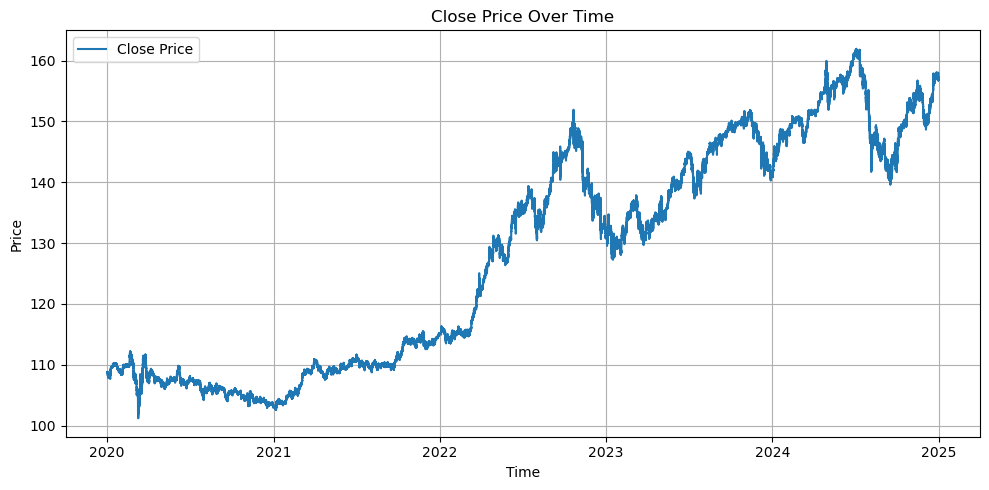

In [12]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and 'timestamp' is datetime type
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['close'], label='Close Price')

plt.title('Close Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
df.to_pickle(RESAMPLED_FILE_PATH)